Eric's note. SLAC Specific instruction
https://confluence.slac.stanford.edu/pages/viewpage.action?pageId=245696522

More general, complete note provided by DM
https://nb.lsst.io/science-pipelines/science-pipelines-in-notebooks.html

download EO utilities
```
$ mkdir src
$ cd src/
$ git clone https://github.com/lsst-camera-dh/EO-utilities.git
$ git clone https://github.com/lsst-camera-dh/datacat-utilities.git
$ wget https://files.pythonhosted.org/packages/57/76/7b745031b9c67e4e7a8aa760a599976347efee9cd0c775051808f50f6d3c/datacat-0.5.tar.gz
$ tar xvzf datacat-0.5.tar.gz
```

edit ~/notebooks/.user_setups
add
```
export PYTHONPATH="~/src/EO-utilities/python":${PYTHONPATH}
export PYTHONPATH="~/src/datacat-utilities/python":${PYTHONPATH}
export PYTHONPATH="~/src/datacat-0.5":${PYTHONPATH}
```
before the below line so that it won't miss the above lines
```
source /gpfs/slac/lsst/fs3/g/data/software/jh_install/prod/setup.sh
```

In [1]:
from lsst import afw
print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil

19.0.0


We have a couple of different flats
- CCOB flat (BOT)
- TS8 flat
- BOT flat taken with Flat Projector
Let's see them one-by-one
https://confluence.slac.stanford.edu/display/LSSTCAM/Flat+comparison

# CCOB flat
The synthesized flats are stored in `/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits`
Let's see the content by using the following command. There are five images for each sensor. Image acquisition was done by placing the projector in the X shape. The one has the projector in the closest to the CCD center is considered as a good image. In file name, there is a projector position in the BOT coordinate. Assuming the following case: 

In [2]:
!ls /gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits | head -5

QE_R01_S00_nm960_-285.985_-159.785.fits
QE_R01_S00_nm960_-285.985_-180.145.fits
QE_R01_S00_nm960_-295.985_-169.965.fits
QE_R01_S00_nm960_-305.985_-159.785.fits
QE_R01_S00_nm960_-305.985_-180.145.fits
ls: write error: Broken pipe


`QE_R12_S00_nm960_-169.185_-42.565.fits` is the best one. Let's take this one as an example:
`/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits`

Let's see the image. The first step is to load an image on memory. get_ccd_from_id return MaskedCCD object with a fits file you specified

In [3]:
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits"
ccd = get_ccd_from_id(None, fname, [])

Display the image with the following function.

In [4]:
import pylab
%matplotlib inline
from astropy.stats import mad_std

def showMaskedCCD(exp, N=3):
    fig, axs = pylab.subplots(2,8,figsize=(5,5),dpi=300)   # create an environment for multiple plot
    for i, amp in enumerate(range(1,17)):                  # loop this over 16 semgents
        ff_det = get_data_as_read(exp, amp, ['imaging'])   # get a specified segment
        mean = ff_det["imaging"].mean()                    # take an average for visualization
        std = mad_std(ff_det["imaging"])                   # take a Median Abosolute Deviation as an estimator for standard deviation
        row = int(i/8)
        col = i%8    
        ax = axs[row][col]
        if row==1:
            origin="lower"
        else:
            origin=None
        ax.imshow(ff_det["imaging"],origin=origin,vmin=mean-N*std,vmax=mean+N*std)
        ax.set_xticks([])
        ax.set_yticks([])
    pylab.show()

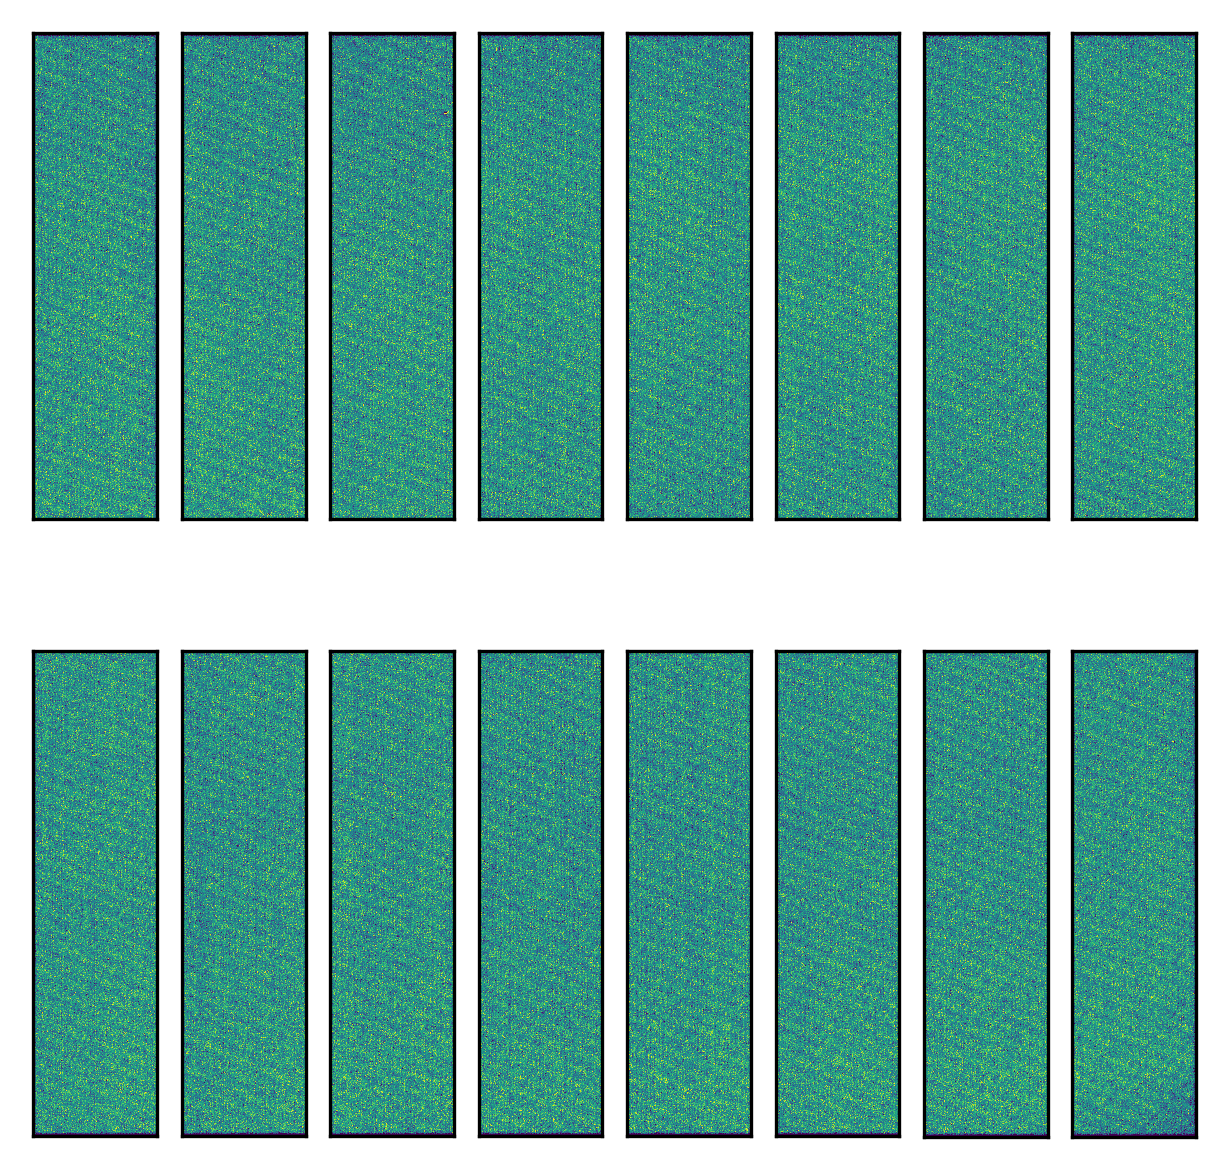

In [5]:
showMaskedCCD(ccd)

# TS8 flat
First we need to figure out which Raft we were looking at. A MaskedCCD object has a information about it. Let's see how it looks.

In [6]:
print(ccd.md.md)

SIMPLE = 1
BITPIX = 8
NAXIS = 0
EXTEND = 1
DATE = "2019-10-29T00:31:19.004"
DATE-OBS = "2019-10-29T00:31:16.602"
MJD = 58785.021747732
MJD-OBS = 58785.021719931
RUNNUM = "6849D"
IMAGETAG = "712568627e31b920"
TSTAND = "BOT"
INSTRUME = "lsstCam"
CONTNUM = "18edfb14"
SEQFILE = "FP_ITL_2s_ir2_v3.seq"
CCDSLOT = "S21"
RAFTBAY = "R02"
LSST_NUM = "ITL-3800C-318"
RAFTNAME = "LCA-11021_RTM-013"
TESTTYPE = "CCOB"
IMGTYPE = "CCOB"
SEQNUM = 4900
DETSIZE = "[1:4072,1:4000]"
CCDTEMP = -102.95257939921
EXPTIME = 0.070000000000000
BINX = 1
BINY = 1
HEADVER = 2
CCDGAIN = 1.0000000000000
CCDNOISE = 10.000000000000
DATE-TRG = "2019-10-29T00:31:16.602"
MJD-TRG = 58785.021719931
FIRMWARE = "31345004"
PLATFORM = "ir2-camera"
DAQVERS = "R4-V2.7 2019-10-25T19:27:48Z (52b5939b)"
DAQPART = "camera"
DAQFOLD = "raw"
DAQANNOT = ""
OBSID = "MC_C_20191028_004900"
TELCODE = "MC"
CONTRLLR = "C"
DAYOBS = "20191028"
TELESCOP = "LSST"
SEQCKSUM = "4046586556"
DARKTIME = 0.19500000000000
TSEQNUM = 225
TEMPLED1 = 20.31054310

You can find what Raft name is by looking at the above output, but specifying a keyword argument will only print what you specified

In [7]:
ccd.md.md["RAFTNAME"]

'LCA-11021_RTM-013'

So this is RTM-013.

Then you have to pick a run number from the table.

Looking at this page List of Good Runs, I can identify which is the good run. For this case Run 10982 is considered as the best for RTM-013. Then I can locate where they are. The below is one example.

/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/ITL-3800C-318_lambda_flat_0800_10982_20190518224505.fits

You are now able to show the flat image.

---

# Below notes have not been well documented.

In [8]:
# Set the path to the Butler repository and import a Butler
repo_path = "/gpfs/slac/lsst/fs3/g/data/datasets/ts8"
butler = Butler(repo_path)

# Get a dataId for the first bias frame for a FE55 run
incompleteDataId = dict(run='6006D', imageType='BIAS', testType='FE55', detectorName='S00')
ss = butler.subset('raw', '', incompleteDataId)
dataId = ss.cache[0]

# Specify the corresponding file
fname = '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/LCA-11021_RTM/LCA-11021_RTM-010-Dev/6006D/fe55_raft_acq/v0/40509/S00/E2V-CCD250-266-Dev_fe55_bias_000_6006D_20180724054018.fits'

# Get the data using the Butler, and using MaskedCCD
exp = get_ccd_from_id(butler, ss.cache[0], [])
ccd = get_ccd_from_id(None, fname, [])

# Get the list of amplifier indexes, 
# Note that this number starts at 0 in butler and and 1 in MaskedCCD
amps_det = get_amp_list(exp)
amps_ccd = get_amp_list(ccd)

# Get the data for amp 3
# This function will return the data as arrays in the readout order,
# which is what we generally want for EO testing
ff_det = get_data_as_read(exp, amps_det[3], ['imaging'])
ff_ccd = get_data_as_read(ccd, amps_ccd[3], ['imaging'])

# Get the imaging data
image_data_det = ff_det['imaging']
image_data_ccd = ff_ccd['imaging']

# Take the mean of the imaging region
mean_det = image_data_det.mean()
mean_ccd = image_data_ccd.mean()

print("Compare means: %.2F %.2F" % (mean_det, mean_ccd))

Unable to determine dark time. Setting from exposure time.


Compare means: 27252.05 27252.05


# Butler Basics
https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/ButlerTutorial.ipynb

## get list of images for superflat
https://github.com/lsst-camera-dh/EO-utilities/blob/e50ab44cbe6d1a33e85ae23170c1b193c15ee904/python/lsst/eo_utils/base/image_utils.py#L1056

In [9]:
dd=get_data_for_run(None, run_id='6006D', testtypes=["QE"], imagetype="FLAT", teststand='ts8')
dd[0]
#get_data_from_run(None,run_id=‘6006D’,testtypes=[“QE”], imagetype=“bias”)

KeyError: 0

In [ ]:
from lsst.eo_utils.base.file_utils import SUPERBIAS_FORMATTER, TS8_FORMATTER
from lsst.eo_utils.sflat.file_utils import SUPERFLAT_FORMATTER
formatter = SUPERFLAT_FORMATTER
fname = formatter(run="6006D", slot="S00", raft="RTM-010",teststand="ts8",testName="sflat",imgtype="FLAT",
          outdir="/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/",calib="normal.fits")
print(fname)

In [ ]:
# Get the data using the Butler, and using MaskedCCD
ccd = get_ccd_from_id(None, fname, [])

# Get the list of amplifier indexes, 
# Note that this number starts at 0 in butler and and 1 in MaskedCCD
amps_ccd = get_amp_list(ccd)

# Get the data for amp 3
# This function will return the data as arrays in the readout order,
# which is what we generally want for EO testing
ff_ccd = get_data_as_read(ccd, amps_ccd[3], ['imaging'])
print (ff_ccd)

In [ ]:
pylab.plot([ x["mean"] for x in selected ] )

In [ ]:
for anid in selected:
    tmp = anid
    print(tmp)
    del tmp["mean"]
    print(tmp)    
    exp = get_ccd_from_id(butler, tmp, [])
    aseg = get_data_as_read(exp, amps_det[3], ['imaging'])
    mean = aseg["imaging"].mean()


https://lsst-camera.slac.stanford.edu/DataPortal/SummaryReport.jsp?run=6006D

In [ ]:
# Get a dataId for the first bias frame for a FE55 run
incompleteDataId = dict(run='6006D', imageType='FLAT', testType='FLAT', detectorName='S00')
ss = butler.subset('raw', '', incompleteDataId)
dataId = ss.cache[1]
print(dataId)
exp = get_ccd_from_id(butler, ss.cache[0], [])
amps_det = get_amp_list(exp)
print(amps_det)

In [ ]:
import pylab
%matplotlib inline
import scipy.stats 
from astropy.stats import mad_std

In [ ]:
def show(exp,amps_det):
    fig, axs = pylab.subplots(2,8,figsize=(5,5),dpi=300)
    for i, amp in enumerate(amps_det):
        ff_det = get_data_as_read(exp, amp, ['imaging'])
        mean = ff_det["imaging"].mean()
        std = mad_std(ff_det["imaging"])
        N = 3
        row = int(i/8)
        col = i%8    
        ax = axs[row][col]
        print(i,row,col, mean, std )
#        ax.set_title("amp{:d}".format(i))
        if row==1:
            origin="lower"
        else:
            origin=None
        ax.imshow(ff_det["imaging"],origin=origin,vmin=mean-N*std,vmax=mean+N*std)
        ax.set_xticks([])
        ax.set_yticks([])
#    pylab.tight_layout()
    pylab.show()


In [ ]:
for im in ss.cache[70:71]:
    exp = get_ccd_from_id(butler, im, [])
    amps_det = get_amp_list(exp)
    show(exp,amps_det)

In [ ]:
from lsst.eo_utils import EOUtils
eo = EOUtils()
data = eo.get_summary_data_run('EOResultsSummary', 'eo_results_sum', '6106D', ['GAIN', 'PTC_GAIN'], dataset='ts8')
